#Τεχνικές Εξόρυξης Δεδομένων - Εργασία 2
---

**Ευγενία Κοζή (1115202000082)**

**Μιχαήλ Βιταντζάκης (1115202000232)**

**Mount Drive**

In [25]:
from google.colab import drive
drive.mount('/content/gdrive')

DIR_PATH = '/content/gdrive/MyDrive/DataMining/'
Location = DIR_PATH + 'books.csv'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Προεπεξεργασία Δεδομένων**

Αφαιρούμε τα nan από τις στήλες 'ratingsByStars', 'genres', 'publishDate' με τις οποίες ασχολούμαστε στην προεπεξεργασία.

In [2]:
import pandas as pd
import numpy as np
import sys

def str_to_list(x, to_int=False):
  x = x[1:-1]
  x = x.split(', ')
  x = [y[1:-1] for y in x]

  if to_int:
    x = [int(y) for y in x]

  return x

# Create Dataframe
df = pd.read_csv(Location, sep=',')
df = df.dropna(subset = ['ratingsByStars', 'genres', 'publishDate'])
df = df[(df['ratingsByStars'] != '[]') & (df['genres'] != '[]')]

# Ratings
df['ratingStar5'] = df['ratingsByStars'].apply(lambda ratings: str_to_list(ratings, True)[0])
df['ratingStar4'] = df['ratingsByStars'].apply(lambda ratings: str_to_list(ratings, True)[1])
df['ratingStar3'] = df['ratingsByStars'].apply(lambda ratings: str_to_list(ratings, True)[2])
df['ratingStar2'] = df['ratingsByStars'].apply(lambda ratings: str_to_list(ratings, True)[3])
df['ratingStar1'] = df['ratingsByStars'].apply(lambda ratings: str_to_list(ratings, True)[4])

# Genre
df['genreSingle'] = df['genres'].apply(lambda genres: str_to_list(genres)[0])

# Date
df['Publish_Year'] = pd.to_datetime(df['publishDate'], format='%m/%d/%y', errors="coerce").fillna(pd.to_datetime(df['publishDate'], format='%B %dth %Y', errors="coerce")).fillna(pd.to_datetime(
  df['publishDate'], format='%B 1st %Y', errors="coerce")).fillna(pd.to_datetime(df['publishDate'], format='%B 2nd %Y', errors="coerce")).fillna(pd.to_datetime(df['publishDate'], format='%B 3rd %Y', errors="coerce"))

**Ερωτήματα για μελέτη των δεδομένων**

Έγιναν τα ερωτήματα 1, 2, 3, 5, 8

Ερώτημα 1: Οι βαθμολογίες ακολουθούν κανονική κατανομή κι έχουν μέσο όρο περίπου 4.

Ερώτημα 8: Τα αγγλικά είναι η γλώσσα στην οποία έχουν γραφτεί τα περισσότερα βιβλία :-)


1) Question 1:


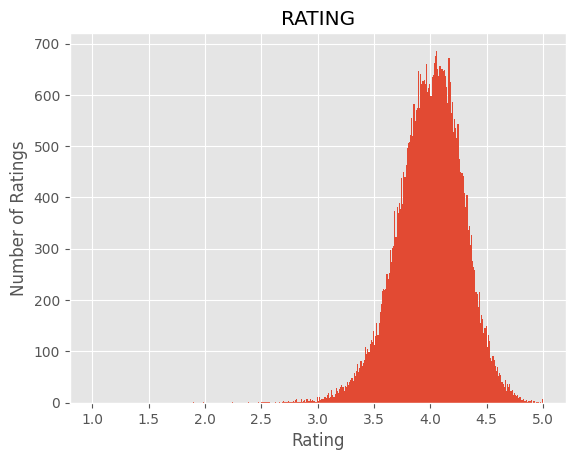


2) Question 2:
                                                title  pages
11490                       The Story of Civilization  14777
22960                      The Complete Wheel of Time  11095
8374          The Complete Malazan Book of the Fallen   8258
5098                                        Animorphs   8245
20098                                       Homestuck   8124
3148                                             Worm   6680
23326                             سه تفنگدار: ١٠ جلدی   6600
4692   The Complete Aubrey/Maturin Novels (5 Volumes)   6576
14269                                البداية والنهاية   6088
1679                           A Song of Ice and Fire   5216

3) Question 3:
                                        title  ratingStar5
32      Harry Potter and the Sorcerer's Stone      4578137
0                            The Hunger Games      3444695
2                       To Kill a Mockingbird      2363896
71       Harry Potter and the Deathly Hallows      2038930
93

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# 1) Question 1
print("\n1) Question 1:")
df = df.dropna(subset = ['rating'])
binwidth = 0.01
plt.hist(df['rating'], bins=np.arange(int(min(df['rating'])), int(max(df['rating'])) + binwidth, binwidth))
plt.title('RATING')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.show()

# 2) Question 2
print("\n2) Question 2:")
df = df.dropna(subset = ['pages'])

for col in ['pages']:
  df = df[df[col].apply(lambda x: str(x).isdigit() or (len(str(x)) == 0))]
  df[col] = df[col].astype(int)

print(df.sort_values(by=['pages'], ascending=False).head(10)[['title', 'pages']])

# 3) Question 3
print("\n3) Question 3:")
print(df[df['ratingStar5'] > 10000].sort_values(by=['ratingStar5'], ascending=False).head(10)[['title', 'ratingStar5']])

# 4) Question 5
print("\n4) Question 5:")
authors, count = np.unique(df['author'], return_counts=True)
df1 = pd.DataFrame(zip(authors, count), columns =['Author', 'Number of Books'])
print(df1.sort_values(by=['Number of Books'], ascending=False).head(10)[['Author', 'Number of Books']])

# 5) Question 8
print("\n4) Question 8:")
df = df.dropna(subset = ['language'])
languages, count = np.unique(df['language'], return_counts=True)
df1 = pd.DataFrame(zip(languages, count), columns =['Language', 'Number of Books'])
print(df1.sort_values(by=['Number of Books'], ascending=False).head(10)[['Language', 'Number of Books']])

**Υλοποίηση Recommendation System**

*   TF-IDF

Έχουμε έναν vectorizer για unigrams κι έναν για bigrams

Δημιουργούμε τη στήλη index από το bookid κρατώντας μόνο τον αριθμό στην αρχή για να το δίνουμε ως όρισμα στις επόμενες συναρτήσεις.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Get the id from the bookId of a book
def get_id(id):
  for index, char in enumerate(id):
    if not char.isdigit():
      return int(id[:index])

df1 = df[['bookId', 'title', 'description', 'language']].dropna(subset = ['description', 'bookId'])
df1 = df1[df1['language'] == 'English']
df1['index'] = df1['bookId'].apply(lambda id: get_id(id))

vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 1))
tfidfs_uni = vectorizer.fit_transform(df1['description'])
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(2, 2))
tfidfs_bi = vectorizer.fit_transform(df1['description'])

*   Cosine Similarity

Έχουμε φτιάξει τη συνάρτηση get_recommendation που υπολογίζει τα num πιο όμοια βιβλία για το βιβλίο που παίρνει ως όρισμα (το κάνει δυναμικά για κάθε βιβλίο κατά την κλήση της). Η συνάρτηση recommend καλεί την get_recommendation δίνοντας τον κατάλληλο vectorizer (unigram, bigram) και εκτυπώνει τα αποτελέσματα.

Χρησιμοποιούμε τους δύο τρόπους για δύο διαφορετικά βιβλία και από τα αποτελέσματα παρατηρούμε ότι το unigram έχει μεγαλύτερη ακρίβεια.

In [ ]:
from sklearn.metrics.pairwise import linear_kernel

def get_recommendation(item_id, num, tfidfs):
  index = df1[df1['index'] == item_id].index[0]
  cosine_similarities = linear_kernel(tfidfs[index], tfidfs).flatten()
  indexes = df1['index'].to_numpy()
  cosine_similarities = np.column_stack((indexes, cosine_similarities))
  cosine_similarities = cosine_similarities[cosine_similarities[:, 1].argsort()]
  related_indexes = np.flip(cosine_similarities[:, 0]).astype(int)
  related_indexes = related_indexes[1:num+1]
  cosine_similarities = np.flip(cosine_similarities[:, 1])
  cosine_similarities = cosine_similarities[1:num+1]

  return related_indexes, cosine_similarities

# Recommends the most similar books
def recommend(item_id, num, choice):
  # Choose tfidfs
  if choice == 1:
    tfidfs = tfidfs_uni
  elif choice == 2:
    tfidfs = tfidfs_bi
  else:
    print("Invalid choice!")
    return

  related_indexes, cosine_similarities = get_recommendation(item_id, num, tfidfs)
  df_related = df1[df1['index'].isin(related_indexes)]
  print("Recommending", num, "books similar to:", list(df1[df1['index']==item_id]['title'])[0])
  print("------------------------------------------------------------")
  for index, (key, row) in enumerate(df_related.iterrows()):
    print("Recommended:", row['title'])
    print("Description:", row['description'])
    print("score:", cosine_similarities[index], "\n")

# Pride and Prejudice
recommend(1885, 5, 1)
recommend(1885, 5, 2)
# Harry Potter and the Order of the Phoenix
recommend(2, 5, 1)
recommend(2, 5, 2)

Recommending 5 books similar to: Pride and Prejudice
------------------------------------------------------------
Recommended: Pride and Prejudice and Zombies
Description: “It is a truth universally acknowledged that a zombie in possession of brains must be in want of more brains.”So begins Pride and Prejudice and Zombies, an expanded edition of the beloved Jane Austen novel featuring all-new scenes of bone-crunching zombie mayhem. As our story opens, a mysterious plague has fallen upon the quiet English village of Meryton—and the dead are returning to life! Feisty heroine Elizabeth Bennet is determined to wipe out the zombie menace, but she’s soon distracted by the arrival of the haughty and arrogant Mr. Darcy. What ensues is a delightful comedy of manners with plenty of civilized sparring between the two young lovers—and even more violent sparring on the blood-soaked battlefield. Can Elizabeth vanquish the spawn of Satan? And overcome the social prejudices of the class-conscious land

* Πίνακες με τα 100 πιο όμοια βιβλία

Κατασκευάζουμε ένα dictionary για unigram κι έναν για bigram. Χρησιμοποιώντας όλα τα βιβλία του dataframe, κάθε dictionary έχει τα 100 πιο όμοια βιβλία για τα 1000 πρώτα βιβλία του dataframe. Η συνάρτηση recommend_dict εκτυπώνει τα num πιο όμοια βιβλία χρησιμοποιώντας το κατάλληλο dictionary. Έχουμε τρέξει το recommend_dict με unigram για ένα από τα δύο βιβλία που χρησιμοποιήσαμε πριν για να διπιστώσουμε ότι έχουμε τα ίδια αποτελέσματα.

In [ ]:
# similarity
dict_sim_uni = {}
dict_sim_bi = {}
num = 100

def recommend_dict(item_id, num, choice):
  # Choose dictionary
  if choice == 1:
    dictionary = dict_sim_uni
  elif choice == 2:
    dictionary = dict_sim_bi
  else:
    print("Invalid choice!")
    return

  related_indexes, cosine_similarities = dictionary[item_id]
  related_indexes = related_indexes[:num]
  cosine_similarities = cosine_similarities[:num]
  df_related = df1[df1['index'].isin(related_indexes)]
  print("Recommending", num, "books similar to:", list(df1[df1['index']==item_id]['title'])[0])
  print("------------------------------------------------------------")
  for index, (key, row) in enumerate(df_related.iterrows()):
    print("Recommended:", row['title'])
    print("Description:", row['description'])
    print("score:", cosine_similarities[index], "\n")

part_of_df1 = df1.head(1000)

for index in part_of_df1['index']:
  related_indexes, cosine_similarities = get_recommendation(index, num, tfidfs_uni)
  dict_sim_uni[index] = (related_indexes, cosine_similarities)

for index in part_of_df1['index']:
  related_indexes, cosine_similarities = get_recommendation(index, num, tfidfs_bi)
  dict_sim_bi[index] = (related_indexes, cosine_similarities)

recommend(2, 5, 1)

Recommending 5 books similar to: Harry Potter and the Order of the Phoenix
------------------------------------------------------------
Recommended: Harry Potter and the Sorcerer's Stone
Description: Harry Potter's life is miserable. His parents are dead and he's stuck with his heartless relatives, who force him to live in a tiny closet under the stairs. But his fortune changes when he receives a letter that tells him the truth about himself: he's a wizard. A mysterious visitor rescues him from his relatives and takes him to his new home, Hogwarts School of Witchcraft and Wizardry.After a lifetime of bottling up his magical powers, Harry finally feels like a normal kid. But even within the Wizarding community, he is special. He is the boy who lived: the only person to have ever survived a killing curse inflicted by the evil Lord Voldemort, who launched a brutal takeover of the Wizarding world, only to vanish after failing to kill Harry.Though Harry's first year at Hogwarts is the best 

**Υλοποίηση Κατηγοριοποίησης (Classification)**

Γίνεται Cleaning αφαιρώντας τα σημεία στίξης και τους αριθμούς επειδή αυτά δε χρησιμεύουν για τη συσχέτιση των λέξεων.

In [3]:
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings("ignore")

def clean_description(desc):

  desc = desc.encode('ascii', 'replace').decode()
  for char in "'`-:,<>()[]{}!?$%^&*_~;\/.+=#@0123456789":
    desc = desc.replace(char, " ")

  desc = desc.replace('"', " ")
  desc = desc.lower()
  desc = desc.strip(".")
  desc = desc.split()

  return desc

df = df.dropna(subset = ['description'])
genres, count = np.unique(df['genreSingle'], return_counts=True)
genres = sorted(zip(count, genres), reverse=True)
genres = list(zip(*genres))[1]
genres = genres[:10]

enumeration = {genre: index for index, genre in enumerate(genres)}

df2 = df[df['genreSingle'].isin(genres)]
descriptions = df2['description'].apply(clean_description)
df2['genreSingle'] = df2['genreSingle'].apply(lambda genre: enumeration[genre])

* Word2Vec

In [45]:
model_w2v = Word2Vec(descriptions, vector_size=250, window=20, min_count=1, negative= 15,sg= 1, workers=3)
model_w2v.save(DIR_PATH + "w2vmodel2.pkl")

**Παραδείγματα - Word2Vec**

Τυπώνουμε τις πιο σχετικές λέξεις ορισμένων λέξεων για να δείξουμε ότι ο vectorizer βγάζει αποδεκτά αποτελέσματα.

In [46]:
model_w2v = Word2Vec.load(DIR_PATH + "w2vmodel2.pkl")

print(model_w2v.wv.most_similar(positive = 'potter'))
print(model_w2v.wv.most_similar(positive = 'hunger'))
print(model_w2v.wv.most_similar(positive = 'prejudice'))
print(model_w2v.wv.most_similar(positive = 'boy'))
print(model_w2v.wv.most_similar(positive = 'cat'))
print(model_w2v.wv.most_similar(positive = 'mafia'))
print(model_w2v.wv.most_similar(positive = 'girl'))
print(model_w2v.wv.most_similar(positive = 'bennet'))
print(model_w2v.wv.most_similar(positive = 'love'))

[('harry', 0.7752926349639893), ('rowling', 0.7017474174499512), ('hogwarts', 0.7010824084281921), ('azkaban', 0.6967139840126038), ('goblet', 0.6782650947570801), ('wizarding', 0.6675847172737122), ('iharry', 0.6603855490684509), ('pottermore', 0.6151484847068787), ('magizoologist', 0.6119760274887085), ('scamander', 0.6101579070091248)]
[('mockingjay', 0.6850974559783936), ('games', 0.6582514047622681), ('everdeen', 0.6565389037132263), ('tributes', 0.6481896042823792), ('katniss', 0.644636332988739), ('panem', 0.6315497159957886), ('mellark', 0.6244771480560303), ('sate', 0.6216806769371033), ('maze', 0.6126932501792908), ('cinna', 0.6099125146865845)]
[('pride', 0.8021702170372009), ('bridebrings', 0.6736778616905212), ('moodiness', 0.668895423412323), ('persuasion', 0.6666005849838257), ('firth', 0.6596953272819519), ('northanger', 0.6585490703582764), ('aylmer', 0.6443608403205872), ('austen', 0.6441275477409363), ('ibi', 0.6433928608894348), ('sephy', 0.643379271030426)]
[('girl

Έχει δημιουργηθεί η συνάρτηση get_dataset ώστε να κωδικοποιεί τα descriptions σε vectors.

In [47]:
from sklearn.model_selection import train_test_split

def get_dataset(wv):
  X = []
  y = []
  for index, desc in enumerate(descriptions):
    vectors = []
    for word in desc:
      if word in wv:
          vectors.append(wv[word])
    np_vectors = np.array([np.array(vector) for vector in vectors])

    if np_vectors.size != 0:
        X.append(np.mean(np_vectors, axis = 0))
        y.append(df2['genreSingle'].values[index])
  return X,y

X, y = get_dataset(model_w2v.wv)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

**Μέθοδοι Classification**

Έχει δημιουργηθεί η συνάρτηση model_report ώστε να τυπώνει τα metrics για το μοντέλο που δίνεται ως όρισμα. Αρχικά τυπώνεται ένα classification report για το test set που δημιουργήθηκε παραπάνω, έπειτα εκτελείται cross validation κι εκτυπώνεται το F1 metric για να πιστοποιηθεί ότι δεν έχει γίνει onerfitting.

In [48]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

def model_report(name, model):
  print(name+':')
  y_pred = model.fit(X_train, y_train).predict(X_test)
  print('Report:')
  print(classification_report(y_pred, y_test))
  scores = cross_val_score(model, X, y, cv= 10, scoring='f1_macro')
  print('Cross validation F1:', scores)

model_report('GaussianNB', GaussianNB())
model_report('BernoulliNB', BernoulliNB())
model_report('Random forest', RandomForestClassifier())

print('Running GridSearchCV for SVM')
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 5,10, 15, 20], 'gamma': ['scale', 'auto',1, 0.1,0.01, 0.001]}
svc = SVC()
grid = GridSearchCV(svc, parameters)
N = 2000
y_pred = grid.fit(X[:N], y[:N])
print('Best parameters:', grid.best_params_)
model_report('SVM', grid.best_estimator_)

GaussianNB:
Report:
              precision    recall  f1-score   support

           0       0.00      0.18      0.00        11
           1       0.02      0.92      0.04        26
           2       0.04      0.48      0.07        52
           3       0.30      0.35      0.32       549
           4       0.30      0.42      0.35       371
           5       0.10      0.36      0.15       111
           6       0.92      0.10      0.17      3589
           7       0.32      0.28      0.30       321
           8       0.17      0.09      0.12       402
           9       0.17      0.38      0.23        82

    accuracy                           0.17      5514
   macro avg       0.24      0.36      0.18      5514
weighted avg       0.69      0.17      0.20      5514

Cross validation F1: [0.13668913 0.144626   0.15347321 0.17447061 0.16797304 0.17904198
 0.18764126 0.19144615 0.17376136 0.15590096]
BernoulliNB:
Report:
              precision    recall  f1-score   support

           

**BONUS - Judging a book by its cover..!**

In [ ]:
import os
import csv
import time
import urllib.request

def get_books_cover(books, bookIds):
  """
  Retrieves books covers to a img/ directory
  Will work on existing books class attribute, so a GoodReads list should be scraped or a books list loaded
  (csv_to_books) before use.
  :return: None
  """
  img_dir = "img/"
  check_folder = os.path.isdir(DIR_PATH + img_dir)

  # If folder doesn't exist, then create it.
  if not check_folder:
    os.makedirs( DIR_PATH + img_dir)
    print("Creating folder: ", img_dir)
  else:
    print(img_dir, "folder already exists, saving images to folder.")

  # Download covers
  for (book, bookId) in zip(books, bookIds):
    urllib.request.urlretrieve(
          book, DIR_PATH + img_dir + bookId  + ".jpg",
    )
    # Set a respectful wait time
    time.sleep(2)

images = df['coverImg'][:100]
Ids = df['bookId'].apply(lambda id: str(get_id(id)))[:100]

get_books_cover(images, Ids)

img/ folder already exists, saving images to folder.


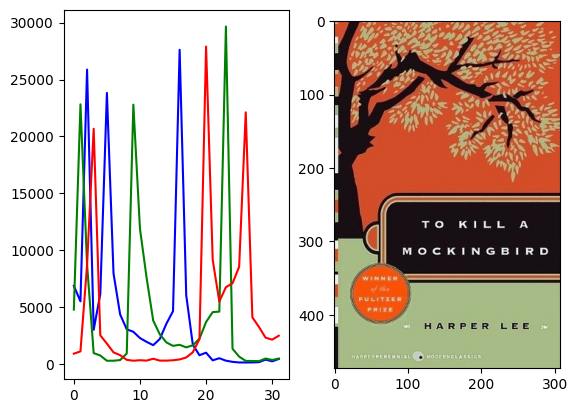

In [ ]:
import cv2
import matplotlib.pyplot as plt

dict_img = {}

for id in Ids:
  path = DIR_PATH + 'img/' + id + '.jpg'
  dict_img[id] = cv2.imread(path)

ids_test = Ids[:2]
ids_compute = Ids[2:]

dict_img_hist = {}

for id in ids_compute:
  histB = cv2.calcHist([dict_img[id]], [0], None,[32], [0,256]) 
  histG = cv2.calcHist([dict_img[id]], [1], None,[32], [0,256]) 
  histR = cv2.calcHist([dict_img[id]], [2], None,[32], [0,256]) 
  dict_img_hist[id] = (histB, histG, histR)

histB, histG, histR = dict_img_hist['2657']
figure, (plt1, plt2) = plt.subplots(1, 2)
plt1.plot(histB, color= 'b')
plt1.plot(histG, color= 'g')
plt1.plot(histR, color= 'r')
plt2.imshow(np.flip(dict_img['2657'], axis= 2))
plt.show()

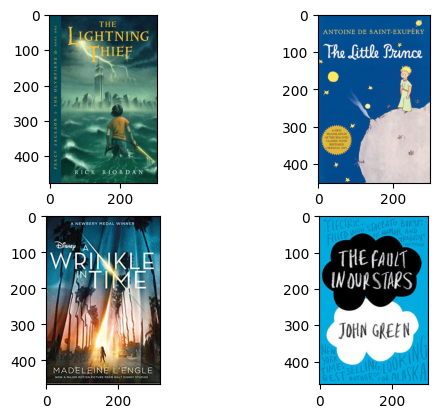

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def get_similar_covers(test_id):
  histB = cv2.calcHist([dict_img[test_id]], [0], None,[32], [0,256]) 
  histG = cv2.calcHist([dict_img[test_id]], [1], None,[32], [0,256]) 
  histR = cv2.calcHist([dict_img[test_id]], [2], None,[32], [0,256]) 
  arr1 = np.append(histB, np.append(histG, histR))
  
  cos_sims = []
  for id in ids_compute:
    histB, histG, histR = dict_img_hist[id]
    arr2 = np.append(histB, np.append(histG, histR))
    cos_sims.append((id, cosine_similarity([arr1], [arr2])[0][0]))

  cos_sims = sorted(cos_sims, key=lambda x: x[1], reverse= True)
  
  imgs = [x[0] for x in cos_sims[:4]]

  figure, plts = plt.subplots(2, 2)

  plts = np.reshape(plts, (1,4))
  plts = plts[0]

  for plot, img in zip(plts, imgs):
    plot.imshow(np.flip(dict_img[img],axis= 2))  
  plt.show()


get_similar_covers('2')